# What's cooking?

Problem Statement - We have to predict the cuisine of recipe using ingredients used in recipe. Training set contain recipe ingredient list and corresponding cuisine and test set contain list of recipe ingredients, we have to predict cuisine.

## Summary
* Libraries used : pandas, matplotlib, seaborn, zipfile, sklearn, xgboost etc.
* TF-IDF representattion is used as word representation
* Two model are used in this notebook : Logistic Regression and XGBoostClassifier
* Models are optimized and evaluated using train-test split and accuracy score is used as error estimate.
* Public Score of models :
  * Logistic Regression : 0.78449
  * XGBoostClassifier : 0.73773

## Steps
* Import Libraries
* Loading data
* Data Preparation
  * Exploring Target data
  * Exploring Ingredients
  * Word Representation
  * Spliting in Train and Validation Set
* Modelling
  * Logistic Regression
  * XGBoostClassifier

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/whats-cooking/train.json.zip
/kaggle/input/whats-cooking/test.json.zip
/kaggle/input/whats-cooking/sample_submission.csv.zip


# Loading Data

In [2]:
zip_train = zipfile.ZipFile('../input/whats-cooking/train.json.zip')
zip_test = zipfile.ZipFile('../input/whats-cooking/test.json.zip')
data_train = pd.read_json(zip_train.read("train.json"))
data_test = pd.read_json(zip_test.read("test.json"))

In [3]:
data_train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
data_test.tail()

,id,ingredients
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo..."
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc..."
9941,22339,"[black pepper, salt, parmigiano reggiano chees..."
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato..."
9943,1443,"[cold water, olive oil, lime wedges, garlic cl..."


# Data Preparation

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


Looks like there is no missing data. Only we have to convert it into model feedable format.

## Exploring Target data

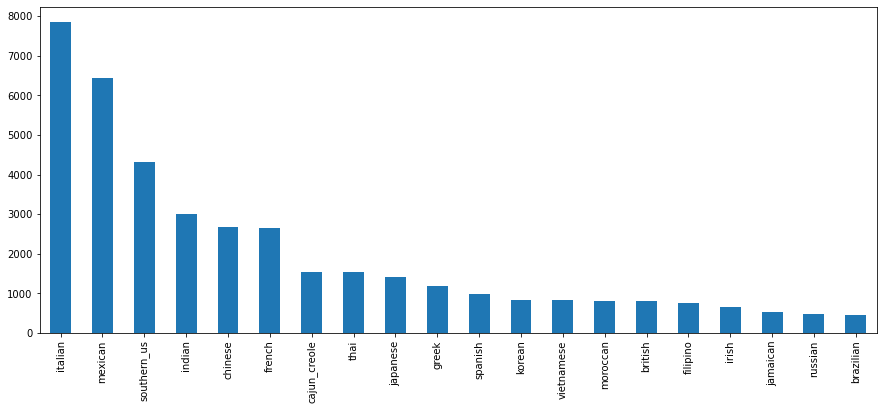

In [7]:
plt.figure(figsize = (15,6))
data_train["cuisine"].value_counts().plot.bar()

## Exploring Ingredients

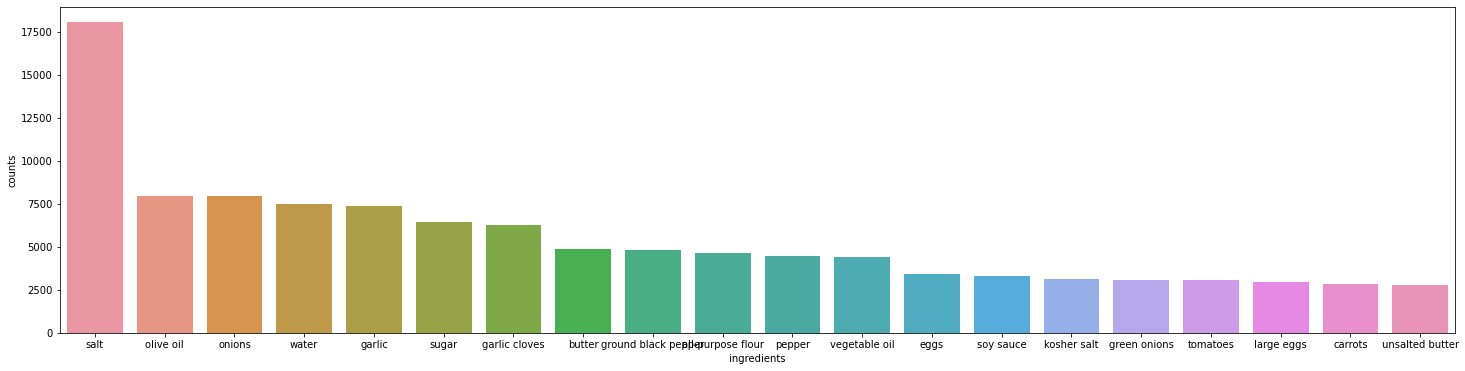

In [8]:
ing_dict = {}
for _,ing_lst in data_train["ingredients"].iteritems():
    for ingredient in ing_lst:
        ing_dict[ingredient] = ing_dict.get(ingredient,0) + 1
ingredients =pd.DataFrame({"ingredients":ing_dict.keys(), "counts": ing_dict.values()}).sort_values(by = "counts", ascending = False).head(20)

plt.figure(figsize = (25,6))
sns.barplot(data = ingredients, x = "ingredients", y = "counts")

It appears that some ingredients are used extensively ie. there is uneven use of ingredients.

# Word Representation

We cannot use list of ingredients as input to model. First we have to convert it into feedable format/representation. Bag of words and Tf-idf are some ways of representation. Word2Vec and GloVe embeddings are some recent ones obtained using RNNs.

I will be using Tf-idf representation. It will take care of uneven use of some ingredients like salt.

In [9]:
# replacing space with underscore to preserve bi-grams like "romaine lettuce" to "romaine_lettuce"
data_train["ingredient_string"] = data_train["ingredients"].map(lambda x: " ".join([a.replace(" ", "_") for a in x]))
data_test["ingredient_string"] = data_test["ingredients"].map(lambda x: " ".join([a.replace(" ", "_") for a in x]))
data_train.head()

,id,cuisine,ingredients,ingredient_string
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine_lettuce black_olives grape_tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain_flour ground_pepper salt tomatoes ground...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking_oil green_c...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable_oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black_pepper shallots cornflour cayenne_pepper...


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_data = vectorizer.fit_transform(data_train["ingredient_string"])
print(X_data.shape, data_train.shape)

(39774, 6867) (39774, 4)


In [11]:
y_data = data_train["cuisine"]

In [12]:
X_test = vectorizer.transform(data_test["ingredient_string"])

# Spliting in train and validation set

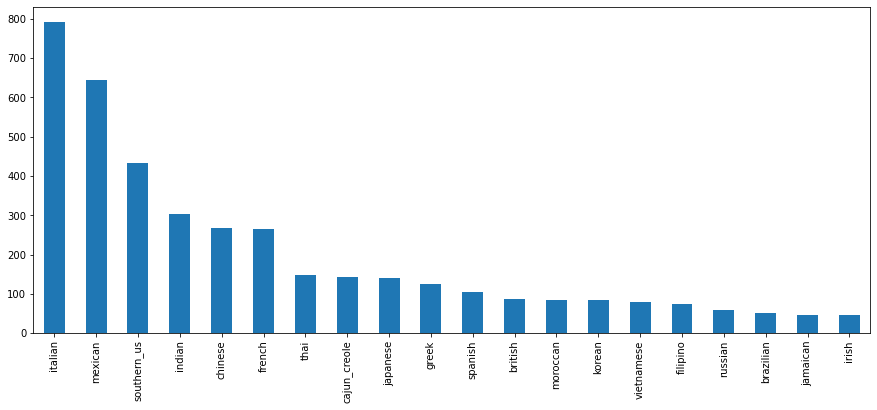

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.1)

plt.figure(figsize = (15,6))
y_valid.value_counts().plot.bar()

# Modeling

I will be using two models Logistic Regression and XGBoostClassifier

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_1 = LogisticRegression(max_iter = 300).fit(X_train, y_train)
predict_1 = model_1.predict(X_valid)
score = accuracy_score(y_valid,predict_1)
score

0.7787833081950729

Optimizing for different values of C.

In [15]:
c_s = [0.01,0.1,1,10]

for i in c_s:
    model = LogisticRegression(max_iter = 500, C = i).fit(X_train, y_train)
    predict1 = model.predict(X_train)
    predict2 = model.predict(X_valid)
    score1 = accuracy_score(y_train,predict1)
    score2 = accuracy_score(y_valid,predict2)
    print("C :",i)
    print(score1,score2)

C : 0.01
0.4511118560733043 0.44997486173956763
C : 0.1
0.6850486087831043 0.6762192056309704
C : 1
0.8323276343725556 0.7787833081950729
C : 10
0.9215834171415801 0.7903469079939668


I will use C = 1, as there is no appreciable increase in test error compared to increase in training error ie, model is overfit at C = 10.

In [16]:
fmodel = LogisticRegression(max_iter = 500, C = 1).fit(X_data, y_data)
fpredict = fmodel.predict(X_test)

In [17]:
subm = data_test[["id"]].copy()
subm["cuisine"] = fpredict
subm.head()

,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [18]:
subm.to_csv("./submissio3.csv", index = False)

# XGBoostClassifier

Here XGBoostClassifier will use eval_set to get best value of n_estimators.

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xmodel = XGBClassifier(n_estimators = 3000, objective='multi:softmax')
xmodel.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 5, verbose = False)
xpredict = xmodel.predict(X_valid)
xscore = accuracy_score(y_valid, predict_1)
xscore

0.7787833081950729

In [20]:
fpredict = xmodel.predict(X_test)

In [21]:
subm = data_test[["id"]].copy()
subm["cuisine"] = fpredict
subm.head()

,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [22]:
subm.to_csv("./submissio4.csv", index = False)